In [75]:
from __future__ import print_function 
%cd /Users/sophiatonelli/library_script/script
from scipy.ndimage import gaussian_filter1d
import tools21cm as t2c
import os, sys 
from scipy.interpolate import interp1d
import math
from scipy.stats import gaussian_kde
os.chdir('/Users/sophiatonelli/library_script/script/work')
sys.path.append(os.getcwd())
import script
sys.path.append(os.getcwd())
import numpy as np 
import matplotlib.pyplot as plt 
import script 
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 11})

/Users/sophiatonelli/library_script/script


AFTER I RUN THE ES-PC SCENARIOS FOR ZETA CONSTANT/MASS INDEPENDENT, I USE THIS CODE TO SELECT 1 SCENARIO WITH RESPECTIVE PARAMETER AND STUDY THE TRENDS OF PC AND ES AS RESOLUTION CHANGES-

In [76]:
gadget_snap = '/Users/sophiatonelli/Downloads/snap_120' 
outpath = '/Users/sophiatonelli/library_script/script/work/script_files' 
scaledist = 1e-3 
default_simulation_data = script.default_simulation_data(gadget_snap, outpath, sigma_8=0.829, ns=0.961, omega_b=0.0482, scaledist=scaledist)

print("Simulation box size:", default_simulation_data.box, "cMpc/h") 
print("Simulation redshift:", default_simulation_data.z) 

Simulation box size: 256.0 cMpc/h
Simulation redshift: 8.0


EXAMPLE xhi=0.2 pc vs es, resolutions (redshift 6)

In [77]:
#select resolution and values for reionization parameters

ngrid = 64 #i.e. resolution 256/128 cMpc/h)
matter_fields = script.matter_fields(default_simulation_data, ngrid, outpath, overwrite_files=False) 
log10Mmin = 9.0  
fcoll_arr = matter_fields.get_fcoll_for_Mmin(log10Mmin) 
xhi_target = 0.5

In [78]:
cell_size=256/ngrid #cMpc/h
print(cell_size, "cMpc/h")

4.0 cMpc/h


0.5536297261714935


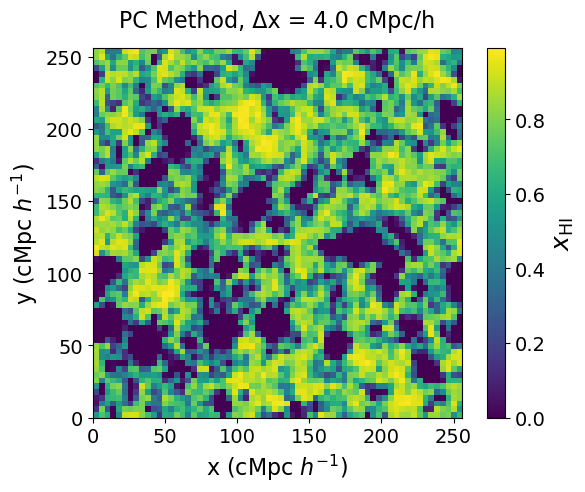

In [79]:
#ionization map for PC method


zeta_pc = 25.07820545231314

ionization_map = script.ionization_map(matter_fields)
qi_arr = ionization_map.get_qi(zeta_pc * fcoll_arr) 
#print(qi_arr)
xhi=1-qi_arr.mean()
print(xhi)

im_q = plt.imshow(1-qi_arr[:,:,int(0.5*ngrid)],extent=[0,default_simulation_data.box,0,default_simulation_data.box], cmap='viridis')
cbar=plt.colorbar(im_q, label=r'$x_{\mathrm{HI}}$')
cbar.ax.yaxis.label.set_size(18)  
cbar.ax.tick_params(labelsize=14)
plt.xlabel(r'x (cMpc $h^{-1}$)', fontsize=16)
plt.ylabel(r'y (cMpc $h^{-1}$)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'PC Method, Δx = {cell_size} cMpc/h', fontsize=16, pad=15)
plt.show()

0.5540164411067963


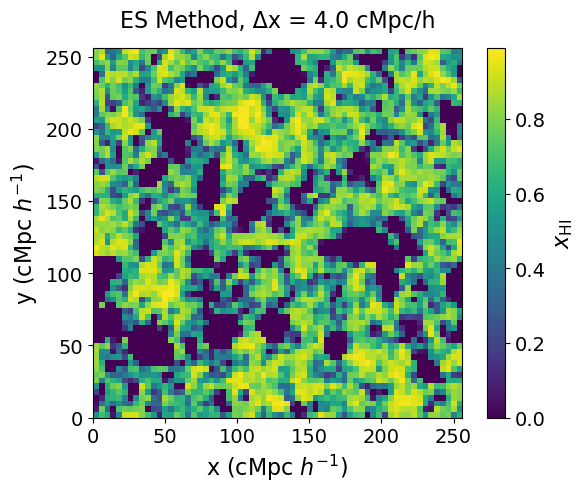

In [80]:
# ionization map for ES method

zeta_es = 26.95 #27.71048  #BASED ON NGRID 64, LOG10Mmin 9.0, and xhi_target 0.20
es_ionization_map = script.ionization_map(matter_fields, method='ES')
es_qi_arr = es_ionization_map.get_qi(zeta_es * fcoll_arr)
print(1-es_qi_arr.mean())
es_im_q = plt.imshow(1 - es_qi_arr[:,:,int(0.5*ngrid)], extent=[0,default_simulation_data.box, 0, default_simulation_data.box], cmap='viridis')
es_cbar = plt.colorbar(es_im_q, label= r'$x_{\mathrm{HI}}$')
es_cbar.ax.yaxis.label.set_size(16)  
es_cbar.ax.tick_params(labelsize=14)
plt.xlabel(r'x (cMpc $h^{-1}$)', fontsize=16)
plt.ylabel(r'y (cMpc $h^{-1}$)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'ES Method, Δx = {cell_size} cMpc/h', fontsize=16, pad=15)
plt.show()

In [81]:
box_size = default_simulation_data.box  #in cMpc/h
cell_size = box_size / ngrid
print("cell size:",cell_size, "cMpc/h")

cell size: 4.0 cMpc/h


In [82]:
# helper functions


def apply_periodic_index(idx, ngrid):
    return idx % ngrid

def apply_periodic_pos(pos, ngrid):
    return np.mod(pos, ngrid)

def choose_random_direction(): 
    theta = np.arccos(np.random.uniform(-1, 1))  #theta range: 0 to pi
    phi = np.random.uniform(0, 2 * np.pi)
    x_vec = np.sin(theta) * np.cos(phi)
    y_vec = np.sin(theta) * np.sin(phi)
    z_vec = np.cos(theta)
    return np.array([x_vec, y_vec, z_vec], dtype=np.float64)

def launching_rays(start_idx, random_direction_vector, ionized_mask, ngrid, cell_size, step_size=1.0): 
    pos = np.array(start_idx, dtype=np.float64)
    distance=0.0
    max_distance = 3 * ngrid 
    while distance < max_distance:
        pos += random_direction_vector * step_size
        pos = apply_periodic_pos(pos, ngrid) 
        idx = np.floor(pos).astype(int) 
        idx = apply_periodic_index(idx, ngrid)
        if not ionized_mask[tuple(idx)]:
            return distance * cell_size 
        distance += step_size      
    return max_distance * cell_size  

In [83]:
# monte carlo sampling: MFP algorithm to determine the bubble size distribution



threshold = 0.5 
num_iterations = 1000000

PC_mean_free_paths = []
ES_mean_free_paths = []

pc_ionized_mask = (qi_arr >= threshold)
es_ionized_mask = (es_qi_arr >= threshold)

for method, ionized_mask in zip(['PC', 'ES'], [pc_ionized_mask, es_ionized_mask]):
    for _ in range(num_iterations):
        idx = np.random.randint(0, ngrid, size=3)
        if not ionized_mask[tuple(idx)]:
            continue
        vector_direction = choose_random_direction()
        mfp = launching_rays(idx, vector_direction, ionized_mask, ngrid, cell_size)
        if method == 'PC':
            PC_mean_free_paths.append(mfp)
        else:
            ES_mean_free_paths.append(mfp)

PC_physical_mfp = np.array(PC_mean_free_paths)
ES_physical_mfp = np.array(ES_mean_free_paths)

print(PC_mean_free_paths)
print(ES_mean_free_paths)
    

[4.0, 8.0, 4.0, 12.0, 4.0, 4.0, 20.0, 0.0, 0.0, 4.0, 0.0, 24.0, 4.0, 16.0, 12.0, 8.0, 0.0, 16.0, 0.0, 4.0, 8.0, 8.0, 12.0, 24.0, 0.0, 0.0, 8.0, 8.0, 0.0, 68.0, 4.0, 4.0, 0.0, 4.0, 16.0, 0.0, 4.0, 4.0, 0.0, 4.0, 8.0, 0.0, 12.0, 4.0, 0.0, 20.0, 4.0, 8.0, 8.0, 12.0, 4.0, 24.0, 4.0, 28.0, 4.0, 8.0, 4.0, 20.0, 16.0, 0.0, 16.0, 16.0, 4.0, 0.0, 0.0, 4.0, 0.0, 12.0, 4.0, 16.0, 16.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 16.0, 0.0, 0.0, 36.0, 0.0, 52.0, 12.0, 0.0, 0.0, 20.0, 28.0, 8.0, 0.0, 4.0, 0.0, 12.0, 56.0, 28.0, 0.0, 24.0, 0.0, 0.0, 12.0, 0.0, 4.0, 4.0, 16.0, 12.0, 0.0, 4.0, 12.0, 4.0, 4.0, 4.0, 12.0, 0.0, 0.0, 16.0, 0.0, 8.0, 12.0, 4.0, 0.0, 4.0, 0.0, 16.0, 32.0, 4.0, 48.0, 0.0, 4.0, 4.0, 4.0, 8.0, 4.0, 20.0, 4.0, 16.0, 0.0, 16.0, 12.0, 0.0, 12.0, 0.0, 0.0, 0.0, 20.0, 8.0, 4.0, 4.0, 20.0, 0.0, 4.0, 0.0, 24.0, 4.0, 20.0, 4.0, 40.0, 12.0, 0.0, 16.0, 4.0, 8.0, 36.0, 0.0, 8.0, 12.0, 8.0, 12.0, 16.0, 8.0, 28.0, 24.0, 24.0, 0.0, 16.0, 16.0, 0.0, 0.0, 24.0, 0.0, 4.0, 72.0, 4.0, 4.0, 20.0, 0.0, 2

In [ ]:
# normalized and interpolated BSDs: 1. PC method, 2. ES method, 3. Tools21cm with PC for comaprison
# determine the peak of the PC BSD



R_min = cell_size 
R_max = box_size
smooth_R = np.linspace(R_min, R_max, 64 ) #128,64 #only 64 bins in this case for pre-fixed resolution
R_dense = np.linspace(smooth_R[0], smooth_R[-1], 1000)

# PC
PC_kde = gaussian_kde(PC_physical_mfp)
PC_smooth_pdf = PC_kde(smooth_R)
PC_bsd = smooth_R * PC_smooth_pdf
PC_bsd /= np.trapz(PC_bsd, smooth_R)
print("PC bsd", np.trapz(PC_bsd, smooth_R))
curve_PC_bsd = interp1d(smooth_R, PC_bsd, kind='cubic', fill_value="extrapolate")
dense_PC_bsd = curve_PC_bsd(R_dense)

# peak
peak_idx = np.argmax(dense_PC_bsd) 
R_peak = R_dense[peak_idx]
peak = dense_PC_bsd[peak_idx]
print("peak", R_peak)
#np.save('R_peak.npy', R_peak)

# ES
ES_kde = gaussian_kde(ES_physical_mfp)
ES_smooth_pdf = ES_kde(smooth_R)
ES_bsd = smooth_R * ES_smooth_pdf
ES_bsd /= np.trapz(ES_bsd, smooth_R)
curve_ES_bsd = interp1d(smooth_R, ES_bsd, kind='cubic', fill_value="extrapolate")
dense_ES_bsd = curve_ES_bsd(R_dense)

# Tools21cm Model
PC_r_mfp, PC_dn_mfp = t2c.mfp(pc_ionized_mask, boxsize=box_size, iterations=10000000)
mask_PC = PC_r_mfp >= R_min
PC_r_mfp = PC_r_mfp[mask_PC]
r_mfp_dense = np.linspace(PC_r_mfp[0], PC_r_mfp[-1], 1000)
PC_dn_mfp = PC_dn_mfp[mask_PC]
PC_dn_mfp /= np.trapz(PC_dn_mfp, PC_r_mfp)  
print("area pdf tools21", np.trapz(PC_dn_mfp, PC_r_mfp))
curve_PC_dn = interp1d(PC_r_mfp, PC_dn_mfp, kind='cubic', fill_value="extrapolate")
dense_PC_dn = curve_PC_dn(r_mfp_dense)

PC bsd 1.0
9.045045045045045
94945/262144 cells are marked as region of interest (ROI).
MFP method applied on 3D data.
Initialising random rays... done
Estimating ray lengths...


100%|██████████| 64/64 [00:21<00:00,  2.95it/s]



Program runtime: 0.44 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
area pdf tools21 1.0


intersection R-values are x1 = 1.9993, x2 = 27.2258
width 23.225757619953914


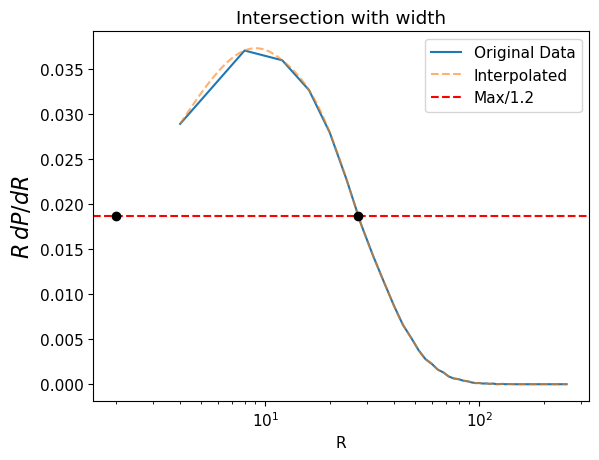

In [85]:
from scipy.optimize import fsolve
from scipy.interpolate import interp1d

# find FWHM from PC BSD



# interpolate PC_bsd over smooth_R
PC_bsd_func = interp1d(smooth_R, PC_bsd, kind='cubic', fill_value="extrapolate")

# target y-value: half the peak height
y_target = dense_PC_bsd[peak_idx] / 2.0

# equation to solve: PC_bsd_func(x) =  y_target 
def equation(x):
    return PC_bsd_func(x) - y_target

#x-values near the peak for initial guesses
x_peak = R_dense[peak_idx]
x1 = fsolve(equation, x_peak - 1)[0] # fsolve: find the roots of a function
x2 = fsolve(equation, x_peak + 1)[0]

print(f"intersection R-values are x1 = {x1:.4f}, x2 = {x2:.4f}")
width= x2 - cell_size
print("width", width)
#np.save("width.npy", width)

# check plot
x_plot = np.linspace(smooth_R.min(), smooth_R.max(), 1000)
y_plot = PC_bsd_func(x_plot)

plt.plot(smooth_R, PC_bsd, label='Original Data')
plt.xscale('log')
plt.plot(x_plot, y_plot, '--', label='Interpolated', alpha=0.6)
plt.axhline(y_target, color='red', linestyle='--', label='Max/1.2')
plt.scatter([x1, x2], [y_target, y_target], color='black', zorder=5)
plt.title('Intersection with width')
plt.xlabel('R')
plt.ylabel(r"$R\,dP/dR$", fontsize=16)
plt.legend()
plt.show()


23.225757619953914 segment length for half max


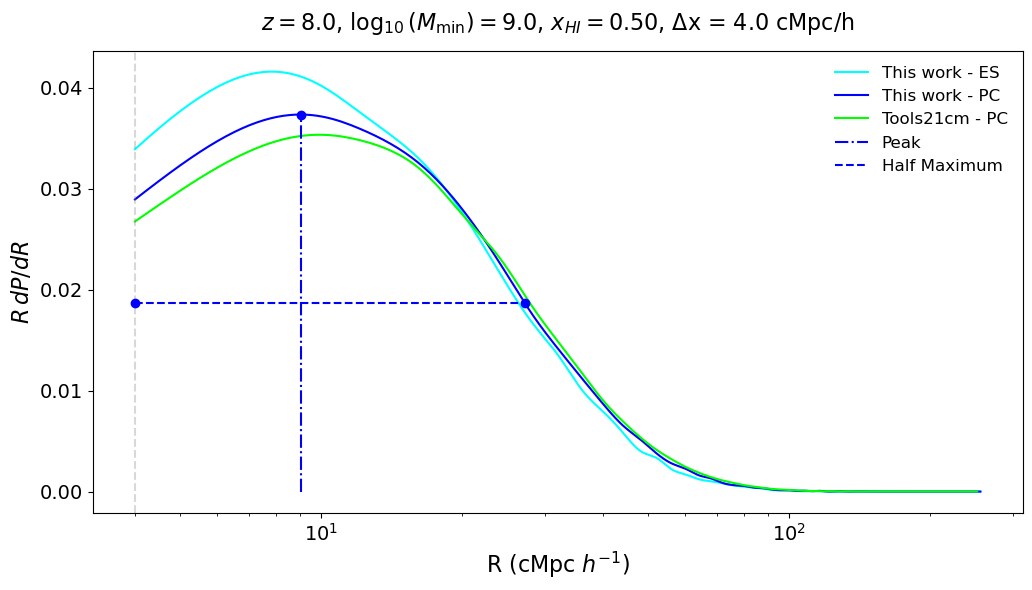

In [86]:
# final sumamry plot 



half_max_segment = x2 - cell_size
print(half_max_segment, "segment length for half max")

plt.figure(figsize=(12,6))

# my algorithm PC + ES BSDs
plt.plot(R_dense, dense_ES_bsd, label = 'This work - ES', color = 'cyan' ) 
plt.plot(R_dense, dense_PC_bsd, label='This work - PC', color='blue') 

# Tools21cm model BSD
plt.plot(r_mfp_dense, dense_PC_dn,label='Tools21cm - PC', color='lime') 

# resolution limit + peak line + FWHM line
plt.axvline(cell_size, linestyle = '--', color='grey', alpha=0.3)
plt.vlines(R_peak, ymin=0, ymax=peak, linestyles='-.', color = 'blue', label = 'Peak')
plt.hlines(y=y_target, xmin=cell_size, xmax=x2, color='blue', linestyle='--', label='Half Maximum') #cell_size
plt.scatter([cell_size, x2], [y_target, y_target], color='blue', zorder=5) #cell_size
plt.scatter(R_peak, peak, color='blue', zorder=5)


plt.legend(fontsize=12, loc='upper right', frameon=False)
plt.title( rf'$z = {default_simulation_data.z}$, 'rf'$\log_{{10}}(M_{{\min}}) = {log10Mmin}$, 'rf'$x_{{HI}}= {xhi_target:.2f}$, 'rf'Δx = {cell_size} cMpc/h', fontsize=16, pad=15)
plt.xscale('log')
plt.xlabel(r'R (cMpc $h^{-1}$)', fontsize=16)
plt.ylabel(r"$R\,dP/dR$", fontsize=16)
plt.tick_params(labelsize=14)
plt.show()

In [87]:
"""
ngrids_list = [128, 64, 32]

labels = ['2cMpc/h Resolution - PC', '2cMpc/h Resolution - ES', '4cMpc/h Resolution - PC', '4cMpc/h Resolution - ES', '8cMpc/h Resolution - PC', '8cMpc/h Resolution - ES']
colors = ['purple', 'blue', 'green', 'red', 'orange', 'pink']

threshold = 0.5
num_iterations = 1000000
log10Mmin = 9.0 
xhi_target = 0.50

zeta_pc = 25.08
zeta_es = 26.95

fig, ax = plt.subplots(figsize=(12,6))
for i, ngrid in enumerate(ngrids_list):
    print("ngrids", ngrid)
    cell_size = box_size/ngrid
    print('cell size', cell_size)
    R_min = cell_size 
    R_max = box_size
    matter_fields = script.matter_fields(default_simulation_data, ngrid, outpath, overwrite_files=True) 
    fcoll_arr = matter_fields.get_fcoll_for_Mmin(log10Mmin) 

    smooth_R = np.linspace(R_min, R_max, ngrid)

    for j, method in enumerate(['PC', 'ES']):
        print("method:", method)
        if method == 'PC':
            ionization_map = script.ionization_map(matter_fields)
            qi_arr = ionization_map.get_qi(zeta_pc * fcoll_arr)
            ionized_mask = (qi_arr >= threshold)
            mean_free_paths = []
            for _ in range(num_iterations):
                idx = np.random.randint(0, ngrid, size=3)
                if not ionized_mask[tuple(idx)]:
                    continue
                vector_direction = choose_random_direction()
                mfp = launching_rays(idx, vector_direction, ionized_mask, ngrid, cell_size)
                mean_free_paths.append(mfp)
            physical_mfp = np.array(mean_free_paths)
            kde = gaussian_kde(physical_mfp) #, bw_method=0.1)
            smooth_pdf = kde(smooth_R)
            print("area pdf", np.trapz(smooth_pdf, smooth_R))
            bsd = smooth_R * smooth_pdf
            bsd /= np.trapz(bsd, smooth_R)
            print("bsd", np.trapz(bsd, smooth_R))
            ax.plot(smooth_R, bsd, label=f'This work - {method} , Δx = {int(box_size/ngrid)} cMpc/h', color=colors[2*i+j])
            ax.axvline(cell_size, linestyle = '--', color='grey', alpha=0.3)
        elif method == 'ES':
            ionization_map = script.ionization_map(matter_fields, method='ES') #method ES
            qi_arr = ionization_map.get_qi(zeta_es * fcoll_arr)
            ionized_mask = (qi_arr >= threshold)
            mean_free_paths = []
            for _ in range(num_iterations):
                idx = np.random.randint(0, ngrid, size=3)
                if not ionized_mask[tuple(idx)]:
                    continue
                vector_direction = choose_random_direction()
                mfp = launching_rays(idx, vector_direction, ionized_mask, ngrid, cell_size)
                mean_free_paths.append(mfp)
            physical_mfp = np.array(mean_free_paths)
            kde = gaussian_kde(physical_mfp)
            smooth_pdf = kde(smooth_R) #,bw_method=0.1)
            print("area pdf", np.trapz(smooth_pdf, smooth_R))
            bsd = smooth_R * smooth_pdf
            bsd /= np.trapz(bsd, smooth_R)
            print("bsd", np.trapz(bsd, smooth_R))
            ax.plot(smooth_R, bsd, label=f'This work - {method} , Δx = {int(box_size/ngrid)} cMpc/h', color=colors[2*i+j])
            ax.axvline(cell_size, linestyle = '--', color='grey', alpha=0.3)

    ax.legend(fontsize=12, loc='upper right', frameon=False)
    ax.set_xscale('log')
    ax.set_xlabel("R (cMpc/h)", fontsize=14)
    ax.set_ylabel(r"$R\,dP/dR$", fontsize=14)
    ax.tick_params(labelsize=14)


plt.gca().text(
  0.98, 0.02,
  rf'$z = {default_simulation_data.z}$, '
          rf'$\log_{{10}}(M_{{\min}}) = {log10Mmin}$, '
          rf'$\langle x_{{\mathrm{{HI}}}} \rangle = {xhi_target:.2f}$',
  fontsize=13,
  color='black',
  fontweight='bold',
  verticalalignment='bottom',
  horizontalalignment='right',
  transform=plt.gca().transAxes
)

plt.show()

"""


'\nngrids_list = [128, 64, 32]\n\nlabels = [\'2cMpc/h Resolution - PC\', \'2cMpc/h Resolution - ES\', \'4cMpc/h Resolution - PC\', \'4cMpc/h Resolution - ES\', \'8cMpc/h Resolution - PC\', \'8cMpc/h Resolution - ES\']\ncolors = [\'purple\', \'blue\', \'green\', \'red\', \'orange\', \'pink\']\n\nthreshold = 0.5\nnum_iterations = 1000000\nlog10Mmin = 9.0 \nxhi_target = 0.50\n\nzeta_pc = 25.08\nzeta_es = 26.95\n\nfig, ax = plt.subplots(figsize=(12,6))\nfor i, ngrid in enumerate(ngrids_list):\n    print("ngrids", ngrid)\n    cell_size = box_size/ngrid\n    print(\'cell size\', cell_size)\n    R_min = cell_size \n    R_max = box_size\n    matter_fields = script.matter_fields(default_simulation_data, ngrid, outpath, overwrite_files=True) \n    fcoll_arr = matter_fields.get_fcoll_for_Mmin(log10Mmin) \n\n    smooth_R = np.linspace(R_min, R_max, ngrid)\n\n    for j, method in enumerate([\'PC\', \'ES\']):\n        print("method:", method)\n        if method == \'PC\':\n            ionization_map

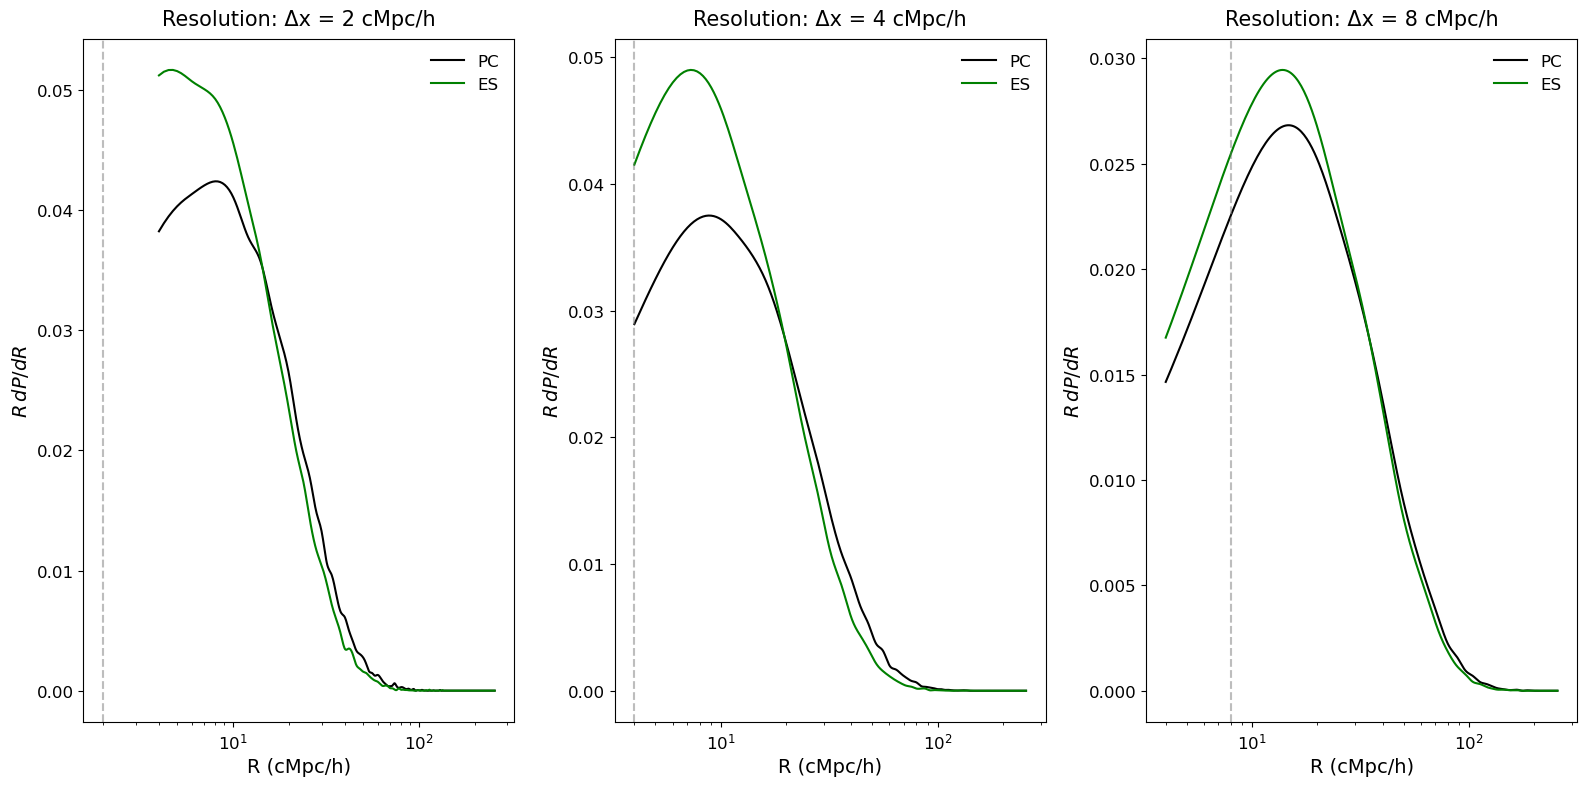

In [ ]:
"""
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
ngrids_list = [128, 64, 32]
colors = ['black', 'green']
labels = ['PC', 'ES']
zeta_pc = 25.07820545231314
list_zeta_es = [27.71048, 26.95, 25.08 ]
threshold = 0.5
num_iterations = 1000000
log10Mmin = 9.0
xhi_target = 0.50

for idx, ngrid in enumerate(ngrids_list):
    box_size = default_simulation_data.box
    cell_size = box_size / ngrid
    R_min = cell_size
    R_max = box_size
    matter_fields = script.matter_fields(default_simulation_data, ngrid, outpath, overwrite_files=True)
    fcoll_arr = matter_fields.get_fcoll_for_Mmin(log10Mmin)
    smooth_R = np.linspace(R_min, R_max, ngrid)
    for j, method in enumerate(['PC', 'ES']):
        if method == 'PC':
            ionization_map = script.ionization_map(matter_fields)
            qi_arr = ionization_map.get_qi(zeta_pc * fcoll_arr)
            ionized_mask = (qi_arr >= threshold)
            mean_free_paths = []
            for _ in range(num_iterations):
                idx_rand = np.random.randint(0, ngrid, size=3)
                if not ionized_mask[tuple(idx_rand)]:
                    continue
                vector_direction = choose_random_direction()
                mfp = launching_rays(idx_rand, vector_direction, ionized_mask, ngrid, cell_size)
                mean_free_paths.append(mfp)
            physical_mfp = np.array(mean_free_paths)
            kde = gaussian_kde(physical_mfp)
            smooth_pdf = kde(smooth_R)
            bsd = smooth_R * smooth_pdf
            bsd /= np.trapz(bsd, smooth_R)
            curve_bsd = interp1d(smooth_R, bsd, kind='cubic', fill_value="extrapolate")
            dense_bsd = curve_bsd(R_dense)
        else:
            for zeta_es in list_zeta_es:
                ionization_map = script.ionization_map(matter_fields, method='ES')
                qi_arr = ionization_map.get_qi(zeta_es * fcoll_arr)
                ionized_mask = (qi_arr >= threshold)
                mean_free_paths = []
                for _ in range(num_iterations):
                    idx_rand = np.random.randint(0, ngrid, size=3)
                    if not ionized_mask[tuple(idx_rand)]:
                        continue
                    vector_direction = choose_random_direction()
                    mfp = launching_rays(idx_rand, vector_direction, ionized_mask, ngrid, cell_size)
                    mean_free_paths.append(mfp)
                physical_mfp = np.array(mean_free_paths)
                kde = gaussian_kde(physical_mfp)
                smooth_pdf = kde(smooth_R)
                bsd = smooth_R * smooth_pdf
                bsd /= np.trapz(bsd, smooth_R)
                curve_bsd = interp1d(smooth_R, bsd, kind='cubic', fill_value="extrapolate")
                dense_bsd = curve_bsd(R_dense)
   
        axs[idx].plot(R_dense, dense_bsd, label=f'{labels[j]}', color=colors[j])
        axs[idx].axvline(cell_size, linestyle='--', color='grey', alpha=0.3)
        axs[idx].set_xscale('log')
        axs[idx].set_xlabel("R (cMpc/h)", fontsize=14)
        axs[idx].set_ylabel(r"$R\,dP/dR$", fontsize=14)
        axs[idx].tick_params(labelsize=12)
        axs[idx].legend(fontsize=12, loc='upper right', frameon=False)
        axs[idx].set_title(f'Resolution: Δx = {int(cell_size)} cMpc/h', fontsize=15, pad=10)

plt.tight_layout()
plt.show()

"""